In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
df=pd.read_csv('train.csv')
for col in df.columns:
    if(df[col].dtype!='object'):
        print(col)
        print(f'Min:{df[col].min()},Max:{df[col].max()}')


Id
Min:1,Max:1460
MSSubClass
Min:20,Max:190
LotFrontage
Min:21.0,Max:313.0
LotArea
Min:1300,Max:215245
OverallQual
Min:1,Max:10
OverallCond
Min:1,Max:9
YearBuilt
Min:1872,Max:2010
YearRemodAdd
Min:1950,Max:2010
MasVnrArea
Min:0.0,Max:1600.0
BsmtFinSF1
Min:0,Max:5644
BsmtFinSF2
Min:0,Max:1474
BsmtUnfSF
Min:0,Max:2336
TotalBsmtSF
Min:0,Max:6110
1stFlrSF
Min:334,Max:4692
2ndFlrSF
Min:0,Max:2065
LowQualFinSF
Min:0,Max:572
GrLivArea
Min:334,Max:5642
BsmtFullBath
Min:0,Max:3
BsmtHalfBath
Min:0,Max:2
FullBath
Min:0,Max:3
HalfBath
Min:0,Max:2
BedroomAbvGr
Min:0,Max:8
KitchenAbvGr
Min:0,Max:3
TotRmsAbvGrd
Min:2,Max:14
Fireplaces
Min:0,Max:3
GarageYrBlt
Min:1900.0,Max:2010.0
GarageCars
Min:0,Max:4
GarageArea
Min:0,Max:1418
WoodDeckSF
Min:0,Max:857
OpenPorchSF
Min:0,Max:547
EnclosedPorch
Min:0,Max:552
3SsnPorch
Min:0,Max:508
ScreenPorch
Min:0,Max:480
PoolArea
Min:0,Max:738
MiscVal
Min:0,Max:15500
MoSold
Min:1,Max:12
YrSold
Min:2006,Max:2010
SalePrice
Min:34900,Max:755000


In [3]:
count=df.isna().sum()
count=count.loc[(lambda x :x>0)].apply(lambda x:np.round(x/df.shape[0]*100,2))

df['SalePrice'].mean()
    

np.float64(180921.19589041095)

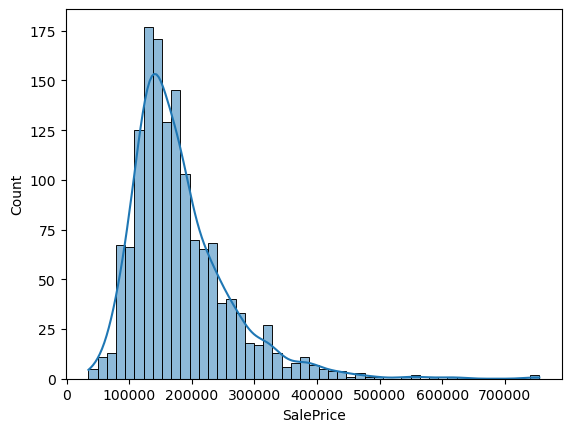

In [4]:
sns.histplot(df,x='SalePrice',kde=True)
plt.show()

In [5]:
df=df.drop(columns=['Id','Alley','PoolQC','Fence','MiscFeature'])
df=df.dropna(subset=['MasVnrArea','Electrical'])


In [6]:
count=df.isna().sum()
count=count.loc[(lambda x :x>0)].apply(lambda x:np.round(x/df.shape[0]*100,2))

In [7]:
num=[]
for col in list(count.index):
    if df[col].dtype!='object':
        num.append(col)

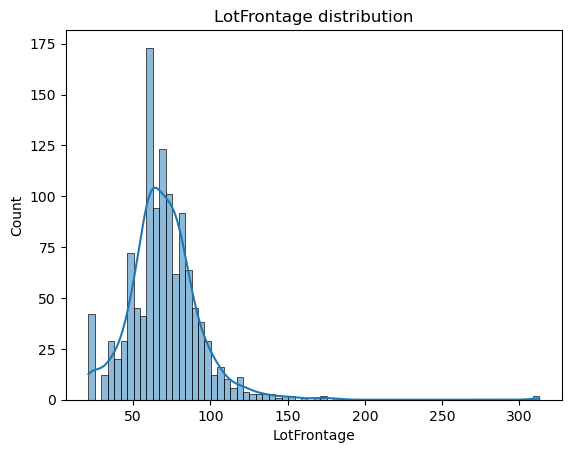

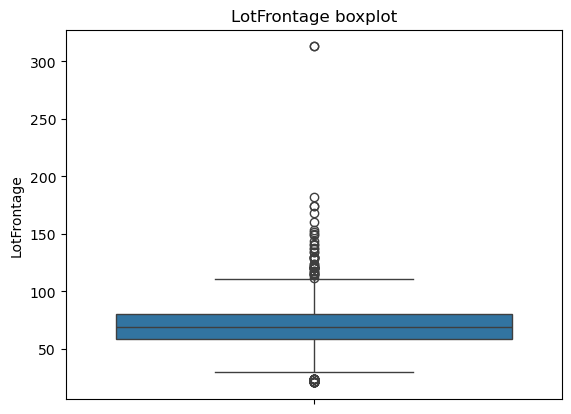

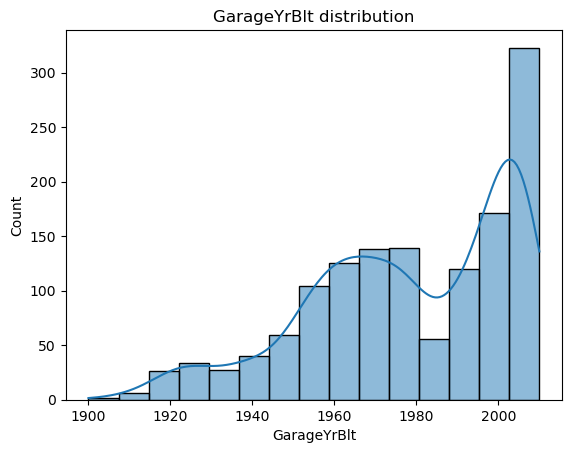

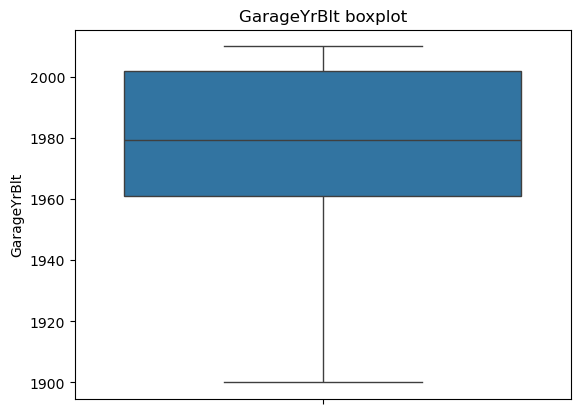

In [8]:
for n in num:
    sns.histplot(df[n],kde=True)
    plt.title(f'{n} distribution')
    plt.show()
    sns.boxplot(df[n])
    plt.title(f'{n} boxplot')
    plt.show()

In [9]:
from sklearn.impute import SimpleImputer
mean_impute=SimpleImputer(strategy='mean')
median_impute=SimpleImputer(strategy='median')
df['LotFrontage']=median_impute.fit_transform(df[[num[0]]])
df[num[1]]=mean_impute.fit_transform(df[[num[1]]])

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
cat_cols=df.select_dtypes(include=['object']).columns
num_cols=df.select_dtypes(exclude=['object']).columns
imp=SimpleImputer(strategy='most_frequent')
df[cat_cols]=imp.fit_transform(df[cat_cols])
preprocessor=ColumnTransformer(transformers=[
    ('cat',OneHotEncoder(sparse_output=False),cat_cols),
    ('num',RobustScaler(),num_cols)
])
df_encoded=preprocessor.fit_transform(df)
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([ohe_feature_names, num_cols])
df_encoded = pd.DataFrame(df_encoded, columns=all_feature_names, index=df.index)

In [11]:
x=df_encoded.drop('SalePrice',axis=1)
y=np.log1p(df['SalePrice'])

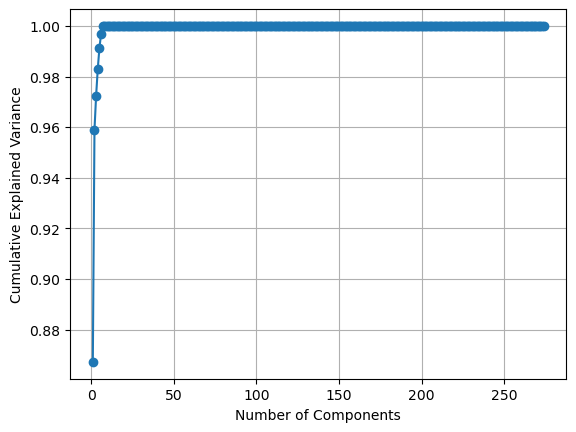

In [12]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(x)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

Since The Variation of model is ambiguous we won t use Dimension Reduction techniques

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchmetrics import MeanSquaredError


In [14]:
class MyDataset(Dataset):
    def __init__(self,feature,target):
        self.x=torch.tensor(feature.values.astype(np.float32),dtype=torch.float32)
        self.y=torch.tensor(target.values.astype(np.float32),dtype=torch.float32).view(-1,1)
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.x.shape[0]
class Net(nn.Module):
    def __init__(self,n_features):
        super().__init__()
        self.layer=nn.Sequential(
            nn.Linear(n_features,256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            
            nn.Linear(256,128),
            nn.ReLU(),
            
            nn.Linear(128,1)
        )
    def forward(self,x):
        return self.layer(x)


In [15]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=18)

In [16]:

train_data=MyDataset(x_train,y_train)
train=DataLoader(train_data,batch_size=64,shuffle=True)
model=Net(x.shape[1])
criterion=nn.SmoothL1Loss()
optim=optim.Adam(model.parameters(),lr=0.003)


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer): Sequential(
    (0): Linear(in_features=274, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [18]:
loss_list=[]
for epoch in range(400):
    model.train()
    running_loss=0
    total_samples=0
    for features,labels in train:
        features=features.to(device)
        labels=labels.to(device)
        optim.zero_grad()
        outputs=model(features)
        loss=criterion(outputs,labels)
        loss.backward()
        optim.step()
        running_loss+=np.sqrt(loss.item()*labels.size(0))
        total_samples+=labels.size(0)
    epoch_loss=running_loss/total_samples
    loss_list.append(epoch_loss)
    


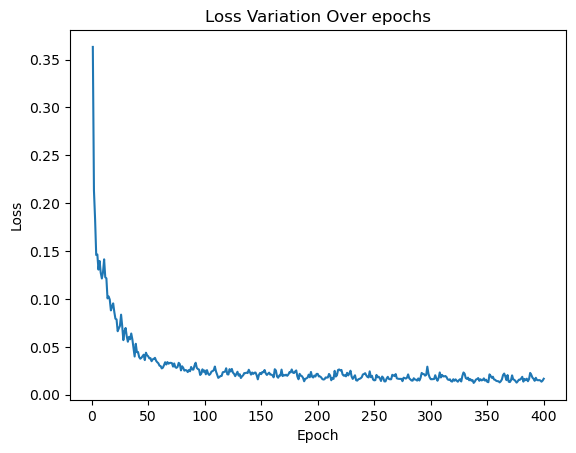

In [19]:
lossdf=pd.DataFrame({'epoch':list(range(1,401)),'loss':loss_list})
sns.lineplot(lossdf,x='epoch',y='loss')
plt.title('Loss Variation Over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [20]:
test_data=MyDataset(x_test,y_test)
test=DataLoader(test_data,batch_size=32,shuffle=True)
mse=MeanSquaredError().to(device)
model.eval()
with torch.no_grad():
    for features,target in test:
        features=features.to(device)
        target=target.to(device)
        outputs=model(features)
        outputs=torch.expm1(outputs)
        target=torch.expm1(target)
        mse.update(outputs,target)
    mse_value=mse.compute()
    rmse_value=torch.sqrt(mse_value)
print(rmse_value)
rmse_value=rmse_value/df['SalePrice'].mean()*100
print(f'My model is ~{rmse_value:.2f}% off an average')

tensor(48768.6602, device='cuda:0')
My model is ~27.00% off an average


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 300, 500, 1000],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True, False]
}
rfcv=GridSearchCV(RandomForestRegressor(),param_grid,scoring='neg_root_mean_squared_error',n_jobs=-1,cv=5)
rfcv.fit(x_train,y_train)
print(f'Best Parmas: {rfcv.best_params_} with a score of :{rfcv.best_score_}')

Best Parmas: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300} with a score of :-0.15058091126741047


In [22]:
from sklearn.metrics import mean_squared_error as MSE
rf=rfcv.best_estimator_

pred=rf.predict(x_test)
pred=np.expm1(pred)
rmse_value=np.sqrt(MSE(pred,np.expm1(y_test)))
print(rmse_value)
rmse_value=rmse_value/df['SalePrice'].mean()*100
print(f'My model is ~{rmse_value:.2f}% off an average')

28520.259191359026
My model is ~15.79% off an average


In [23]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.5, 1],  # L1 regularization
    'reg_lambda': [1, 1.5, 2],  # L2 regularization
    'n_estimators': [100, 200],  # total trees
}

xgb_cv=RandomizedSearchCV(XGBRegressor(tree_method='gpu_hist',predictor='gpu_predictor'),xgb_param_grid,scoring='neg_root_mean_squared_error',n_jobs=-1,cv=5)
xgb_cv.fit(x_train,y_train)
print(f'Best Parmas: {xgb_cv.best_params_} with a score of :{xgb_cv.best_score_}')

C:\Users\melki\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [17:49:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\melki\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [17:49:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parmas: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0} with a score of :-0.13977306840078488


In [25]:
xgb=xgb_cv.best_estimator_
pred=xgb.predict(x_test)
pred=np.expm1(pred)
rmse_value=np.sqrt(MSE(pred,np.expm1(y_test)))
print(rmse_value)
rmse_value=rmse_value/df['SalePrice'].mean()*100
print(f'My model is ~{rmse_value:.2f}% off an average')

25023.677799015146
My model is ~13.85% off an average


As You can See a tuned XGBoost preform better than RF and NN